In [1]:
import os, sys, json
import numpy as np
import torch as ch
import resource
from tqdm.notebook import tqdm
from robustness.model_utils import make_and_restore_model
from robustness.tools.vis_tools import show_image_row
from robustness import datasets
from robustness.tools.label_maps import CLASS_DICT
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from objectnet_utils import load_ObjectNet, map_ImageNetToObjectNet, OBJN_TO_IN_MAP

sns.set_style('darkgrid')

In [2]:
DATA_DIR = '/scratch/datasets/sandbox/objectnet-1.0' 
dataset, test_loader, label_map = load_ObjectNet(DATA_DIR)

==> Preparing dataset imagenet..


In [3]:
_, (im, targ) = next(enumerate(test_loader))

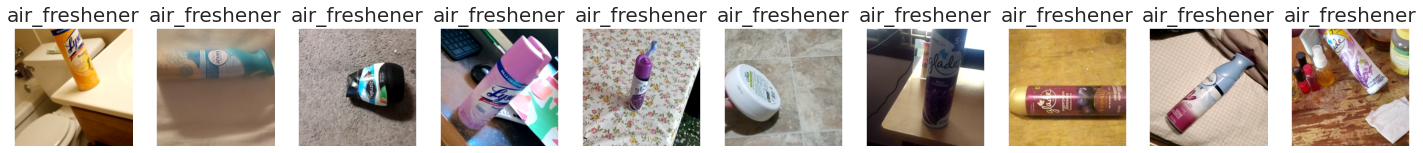

In [4]:
show_image_row([im[:10]], tlist=[[label_map[int(t)] for t in targ]],
               fontsize=20)

In [5]:
obj_to_in_map, obj_folder_to_label = map_ImageNetToObjectNet(DATA_DIR, label_map)

## Get model

In [9]:
IN_DIR = '/scratch/engstrom_scratch/imagenet'

In [10]:
m, _ = make_and_restore_model(arch='resnet18', 
                                          dataset=datasets.ImageNet(IN_DIR),
                                          pytorch_pretrained=True)
m.eval()
m = ch.nn.DataParallel(m.cuda())

In [8]:
def get_preds(model, loader, map_dict, mode='restrict'):
    total = [0, 0]
    in_classes = list(set(map_dict.values()))
    with ch.no_grad():
        for _, (im, targ) in enumerate(loader):
            op, _ = model(im)
            if mode != 'restrict':
                pred = ch.argmax(op, dim=1).cpu()
            else:
                # ch.gather
                op = op[:, in_classes]
                pred = ch.argmax(op, dim=1).cpu()
                pred = ch.tensor([in_classes[int(p)] for p in pred])
                
            corr = []
            for p, l in zip(pred, targ):
                if int(l) not in map_dict: continue
                corr.append((ch.tensor(map_dict[int(l)]) == p).item())
            total[0] += sum(corr)
            total[1] += len(corr)
    return total

In [9]:
acc = get_preds(m, test_loader, obj_to_in_map)

In [10]:
acc[0] / acc[1]

0.26773135451954616

## Load synthetic data

In [2]:
from pathlib import Path
from torchvision import transforms
from utils import RGBAToRGB, ModelDataset, details_df
from colorsys import hsv_to_rgb, rgb_to_hsv
from make_predictions import make_predictions

In [3]:
DS_PATH = '/scratch/datasets/sandbox/v0'
ds_path = Path(DS_PATH)
root_df = details_df(ds_path)
ds = datasets.ImageNet((ds_path, root_df))

In [4]:
ds.custom_class = ModelDataset
ds.custom_class_args = {
    'subset': 1000
}
ds.transform_test = transforms.Compose([
            RGBAToRGB(hsv_to_rgb(1, 1, 1)),
            #transforms.CenterCrop((40, 40)),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])

In [5]:
_, loader = ds.make_loaders(workers=10, 
                            batch_size=10, 
                            only_val=True)

==> Preparing dataset imagenet..


In [6]:
_, res = next(enumerate(loader))
im, targ = res[0], res[1]

In [7]:
show_image_row([im[:10]], tlist=[[label_map[int(t)] for t in targ]],
               fontsize=20)

NameError: name 'label_map' is not defined

In [11]:
acc_df = make_predictions(m, ds, OBJN_TO_IN_MAP, 
                          mode='restrict',
                         workers=8, batch_size=100)

  0%|          | 0/10 [00:00<?, ?it/s]

==> Preparing dataset imagenet..


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


In [12]:
100 * np.mean(acc_df['labs'] == acc_df['preds'])

20.200000000000003

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
CM = confusion_matrix(acc_df['labs'], acc_df['preds'], normalize='true')

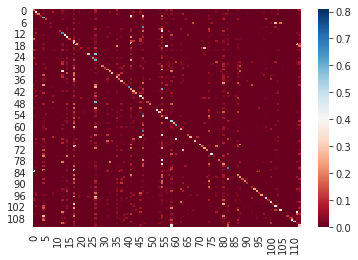

In [22]:
sns.heatmap(CM, cmap='RdBu')
plt.show()

/opt/miniconda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


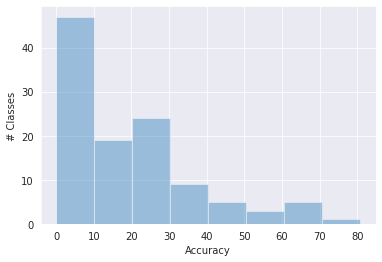

In [23]:
sns.distplot(100 * np.diag(CM), kde=False)
plt.xlabel('Accuracy')
plt.ylabel('# Classes')
plt.show()

In [24]:
idx = np.argsort(np.diag(CM))[::-1]

print([(label_map[l], f"{100 * np.diag(CM)[l]:.2f}") for l in idx[:10]])

[('board_game', '80.82'), ('dress_shirt', '66.73'), ('beer_bottle', '64.82'), ('butter', '64.67'), ('coffee_french_press', '63.21'), ('bookend', '60.66'), ('banana', '59.47'), ('coaster', '52.71'), ('extension_cable', '51.23'), ('bike_pump', '49.16')]


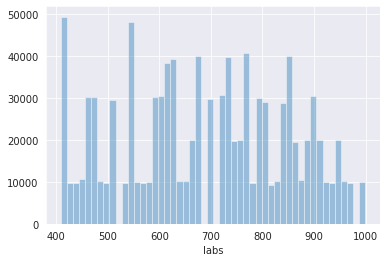

In [25]:
sns.distplot(acc_df['labs'], kde=False)
plt.show()

In [26]:
len(acc_df['labs'])

1002650

In [27]:
obj_to_in_map

{1: 409,
 2: 414,
 4: 954,
 5: 419,
 8: 790,
 9: 434,
 12: 440,
 15: 703,
 16: 671,
 19: 446,
 28: 455,
 34: 930,
 37: 462,
 38: 463,
 39: 499,
 43: 473,
 44: 470,
 47: 487,
 51: 423,
 56: 588,
 60: 550,
 66: 507,
 67: 673,
 73: 846,
 116: 533,
 78: 539,
 83: 630,
 85: 740,
 86: 968,
 89: 729,
 96: 549,
 100: 545,
 107: 567,
 80: 578,
 111: 589,
 114: 587,
 120: 560,
 124: 606,
 128: 608,
 131: 508,
 132: 618,
 133: 619,
 135: 620,
 138: 951,
 139: 623,
 142: 626,
 143: 629,
 149: 644,
 150: 647,
 151: 651,
 153: 659,
 154: 664,
 157: 504,
 160: 677,
 164: 679,
 171: 950,
 173: 695,
 175: 696,
 179: 700,
 182: 418,
 188: 720,
 190: 721,
 191: 725,
 193: 728,
 196: 923,
 199: 731,
 200: 737,
 201: 811,
 205: 742,
 210: 761,
 216: 769,
 217: 770,
 218: 772,
 219: 773,
 220: 774,
 223: 783,
 229: 792,
 231: 601,
 232: 797,
 235: 804,
 236: 806,
 237: 809,
 238: 813,
 239: 632,
 248: 732,
 250: 828,
 251: 850,
 253: 834,
 255: 837,
 256: 841,
 257: 842,
 258: 610,
 287: 851,
 267: 849,
 26